In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Path to train images
train_dir = '../input/plant-seedlings-classification/train/'
train_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/seg_train/'
train_dir_large = '../input/plantseedlingslarge/plant-seedlings-large/train-large/'
train_dir_seg_large = '../input/plantseedlingslarge/plant-seedlings-large/train-large-seg/'


# Path to test images
test_dir = '../input/plant-seedlings-classification/'
test_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/'

In [3]:
train = train_dir_seg_large
test = test_dir_seg

In [4]:
epochs     = 70
batch_size   = 16
width        = 299
height       = 299

In [5]:
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                 "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

In [6]:
from keras.applications.xception import Xception, preprocess_input

In [7]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.15,
    )

    train_generator = train_datagen.flow_from_directory(
        directory=train,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='training',
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=train,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='validation',
        shuffle=False
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=180,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            vertical_flip=True,
            horizontal_flip=True)

    test_generator = test_datagen.flow_from_directory(
        directory=test,
        classes=['seg_test'],
        target_size=(width, height),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

In [8]:
train_generator, validation_generator, test_generator = define_generators()

Found 10200 images belonging to 12 classes.
Found 1800 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


In [9]:
# define appropriate callbacks
def training_callbacks():
    
    # save best model regularly
    save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.h5',
        monitor = 'loss', save_best_only = True, verbose = 1)
    
    # reduce learning rate when it stops decreasing
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.4,
                              patience = 3, min_lr = 1e-10, verbose = 1, cooldown = 1)
    
    # stop training early if no further improvement
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'loss', min_delta = 1e-2, patience = 10, verbose = 1,
        mode = 'min', baseline = None, restore_best_weights = True
    )

    return save_best_model, reduce_lr, early_stopping


In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten


def create_model():
    model_main = Xception(weights='imagenet', input_shape=(width, height, 3), include_top=False)
    layer = model_main.output
    layer = GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = BatchNormalization()(layer)
    
    layer = Dropout(0.2, name="top_dropout")(layer)

    dropout_1 = tf.keras.layers.Dropout(0.2)(layer)
    model_dense2 = tf.keras.layers.Dense(256, activation = 'selu', activity_regularizer=tf.keras.regularizers.l2(1e-5))(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2)(model_dense2)
    model_dense3 = tf.keras.layers.Dense(128, activation='selu')(dropout_2)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense3)

    model = tf.keras.models.Model(model_main.input,  model_out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [11]:
model = create_model()
model.summary()

2022-04-11 03:32:14.093402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:32:14.217461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:32:14.218276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 03:32:14.219750: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [12]:
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks = training_callbacks()
)

2022-04-11 03:32:18.946324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-04-11 03:32:24.236333: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


637/637 [==============================] - 438s 670ms/step - loss: 1.0913 - accuracy: 0.6511 - val_loss: 0.4996 - val_accuracy: 0.8203

Epoch 00001: loss improved from inf to 1.09134, saving model to model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/70
637/637 [==============================] - 365s 572ms/step - loss: 0.5447 - accuracy: 0.8122 - val_loss: 0.3464 - val_accuracy: 0.8811

Epoch 00002: loss improved from 1.09134 to 0.54474, saving model to model.h5
Epoch 3/70
637/637 [==============================] - 366s 574ms/step - loss: 0.4247 - accuracy: 0.8539 - val_loss: 0.3183 - val_accuracy: 0.8951

Epoch 00003: loss improved from 0.54474 to 0.42470, saving model to model.h5
Epoch 4/70
637/637 [==============================] - 366s 574ms/step - loss: 0.3583 - accuracy: 0.8764 - val_loss: 0.2592 - val_accuracy: 0.9079

Epoch 00004: loss improved from 0.42470 to 0.35834, saving model to model.h5
Epoch 5/70
637/637 [==============================] - 367s 575ms/step - loss: 0.3256 - accuracy: 0.8888 - val_loss: 0.2075 - val_accuracy: 0.9241

Epoch 00005: loss improved from 0.35834 to 0.32559, saving model to model.h5
Epoch 6/70
637/637 [==============================] - 368s 578ms/step - loss: 0.2911 - accuracy: 0.8993 

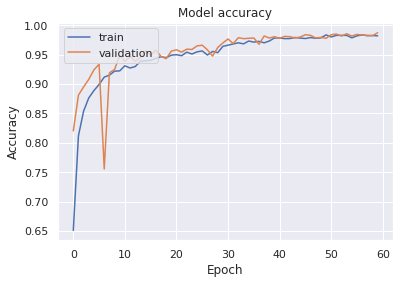

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = "validation")
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy.png')

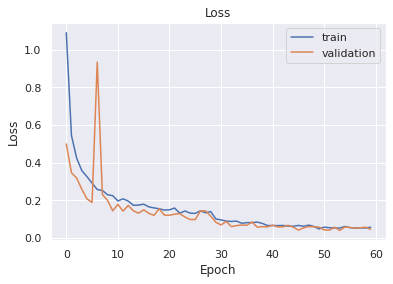

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = "validation")
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss.png')

In [15]:
model.save_weights('xception.h5')

(1800, 12)


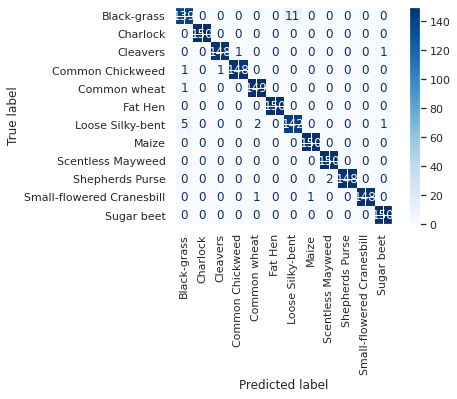

In [16]:
validation_generator.reset() 
val_pred = model.predict(validation_generator, steps=validation_generator.samples)
print(val_pred.shape)
y_pred = np.argmax(val_pred, axis = 1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [17]:
predictions = model.predict(test_generator, steps=test_generator.samples)

class_list = []

for i in range(0, predictions.shape[0]):
    y_class = predictions[i, :].argmax(axis=-1)
    class_list += [species_list[y_class]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'seg_test/', '')
submission['species'] = class_list

submission.to_csv('xception_seg_submission.csv', index=False)

print('Submission file generated. All done.')

Submission file generated. All done.
